In [1]:
import ROOT
import math
# Colors
from ROOT import kYellow, kBlue, kRed, kGreen
import numpy as np
from rootpy.plotting import Hist, HistStack, Legend, Canvas, set_style
from rootpy.plotting.style import get_style, set_style
from rootpy.plotting.utils import draw
from rootpy.interactive import wait
import rootpy.plotting.root2matplotlib as rplt
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator, MultipleLocator
from root_numpy import root2array, tree2array
from root_numpy import testdata, fill_hist
import pandas as pd

Welcome to JupyROOT 6.14/04


DEBUG:matplotlib] $HOME=/home/andrea
DEBUG:matplotlib] matplotlib data path /home/andrea/anaconda3/lib/python3.5/site-packages/matplotlib/mpl-data
DEBUG:matplotlib] loaded rc file /home/andrea/anaconda3/lib/python3.5/site-packages/matplotlib/mpl-data/matplotlibrc
DEBUG:matplotlib] matplotlib version 2.2.3
DEBUG:matplotlib] interactive is False
DEBUG:matplotlib] platform is linux
DEBUG:matplotlib] loaded modules: ['jedi.evaluate.compiled.context', 'dateutil.parser._parser', 'IPython.lib', 'prompt_toolkit.lexers.pygments', 'urllib.parse', 'jedi.evaluate.lazy_context', 'typing.re', 'filecmp', 'jedi.evaluate.finder', 'ipywidgets', '_operator', 'concurrent.futures', 'ipykernel._version', 'ROOT.vector<float>', 'prompt_toolkit.styles.defaults', 'importlib.machinery', 'pydoc_data.topics', 'prompt_toolkit.styles', 'ROOT.TObject', 'dateutil', 'selectors', 'jupyter_client.jsonutil', 'errno', 'ptyprocess', 'optparse', 'prompt_toolkit.layout.layout', 'encodings', 'cython_runtime', 'email.feedparser

DEBUG:matplotlib] CACHEDIR=/home/andrea/.cache/matplotlib
DEBUG:matplotlib.font_manager] Using fontManager instance from /home/andrea/.cache/matplotlib/fontList.json
DEBUG:matplotlib.backends] backend module://ipykernel.pylab.backend_inline version unknown
DEBUG:matplotlib.backends] backend module://ipykernel.pylab.backend_inline version unknown


## Matplotlib Function

In [2]:
def getTHLimits(file_path, ttree, var):
    g_min = 99999999999.
    g_max = -99999999999.
    aux = ROOT.TFile.Open(file_path)
    tree = aux.Get(ttree)
    maxv=int(round(tree.GetMaximum(var)))
    minv=int(round(tree.GetMinimum(var)))
    return minv-1.,maxv+1.

In [82]:
def hist_gen(file, data, background, signal, ttree, var, region, nbins):
    
    rfile = ROOT.TFile(file)
    intree = rfile.Get(ttree)
    array = tree2array(intree)
    df = pd.DataFrame(array)
    df = df.loc[df['m_region'] == region]
    
    # data, background and signal are filenames arrays
    arrB = df.loc[df['sample'].isin(background)]
    arrS = df.loc[df['sample'].isin(signal)]
    arrD = df.loc[df['sample'].isin(data)]
    
    # Integrals
    intB = []
    intS = []
    intD = []
    
    # set the style
    style = get_style('ATLAS')
    style.SetEndErrorSize(3)
    set_style(style)
    
    # create histograms
    hmin, hmax = getTHLimits(file, ttree, var)
    h = Hist(nbins, hmin, hmax, markersize=0)
    h_sig = []
    h_bkg = []
    colorsS = ['red', 'firebrick']
    colorsB = ['blue', 'green', 'yellow', 'cyan', 'magenta', 'navy', 'orange', 'yellowgreen', 'chocolate', 'darkviolet', 'm', 'steelblue']
    for i, s in enumerate(signal):
        h_aux = Hist(nbins, hmin, hmax, title=s+"x10", color=colorsS[i])
        arr_aux = arrS.loc[arrS['sample'] == s]
        fill_hist(h_aux, arr_aux.loc[:,var], arr_aux.loc[:,'EventWeight'])
        intS.append(h_aux.Integral())
        #h_aux.fillstyle = 'solid'
        #h_aux.fillcolor = colorsS[i]
        #h_aux.linecolor = colorsS[i]
        #h_aux.linewidth = 1
        h_sig.append(h_aux*10)
    for i, b in enumerate(background):
        h_aux = h.Clone(title=b, legendstyle='F')
        arr_aux = arrB.loc[arrB['sample'] == b]
        fill_hist(h_aux, arr_aux.loc[:,var], arr_aux.loc[:,'EventWeight'])
        h_aux.fillstyle = 'solid'
        h_aux.fillcolor = colorsB[i]
        h_aux.linecolor = colorsB[i]
        h_aux.linewidth = 0
        intB.append(h_aux.Integral())
        h_bkg.append(h_aux)

    h_data = h.Clone(title=data[0])
    h_data.markersize = 1.2
    arr_aux = arrD.loc[arrD['sample'] == data[0]]
    fill_hist(h_data, arr_aux.loc[:,var], arr_aux.loc[:,'EventWeight'])
    intD.append(h_data.Integral())

    # histograms stack
    stack = HistStack(h_bkg, drawstyle='HIST E1 X0')

    # plot with ROOT
    canvas = Canvas(width=1000, height=800)
    draw([stack, h_data, h_sig[0]], xtitle=var, ytitle='Events', pad=canvas)
    
    # set the number of expected legend entries
    legend = Legend(h_bkg, leftmargin=0.25, margin=0.1, pad=canvas)
    legend.Draw()
    label = ROOT.TText(0.2, 0.6, 'ROOT')
    label.SetTextFont(43)
    label.SetTextSize(15)
    label.SetNDC()
    label.Draw()
    canvas.Modified()
    canvas.Update()

    # plot with matplotlib
    set_style('ATLAS')
    fig = plt.figure(figsize=(9, 8), dpi=100)
    axes = plt.axes()
    axes.xaxis.set_minor_locator(AutoMinorLocator())
    axes.yaxis.set_minor_locator(AutoMinorLocator())
    rplt.bar(stack, stacked=True, axes=axes)
    rplt.bar(h_sig, stacked=False, axes=axes)
    rplt.errorbar(h_data, xerr=False, emptybins=False, axes=axes)
    plt.xlabel(var, va='bottom', ha='right')
    plt.ylabel('Events', va='top', ha='right')
    axes.xaxis.set_label_coords(1., -0.1)
    axes.yaxis.set_label_coords(-0.1, 1.)
    leg = plt.legend()
    plt.grid()
    plt.savefig("plots/"+var+"_"+region+".png")
    
    if not ROOT.gROOT.IsBatch():
        plt.show()
        # wait for you to close the ROOT canvas before exiting
        wait(True)
    canvas.Draw()
    
    #fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(8,6), sharey=True, sharex=True)
    
    return intB, intS, intD
    

INFO:rootpy.plotting.style] using ROOT style 'ATLAS'
INFO:rootpy.plotting.style] using ROOT style 'ATLAS'


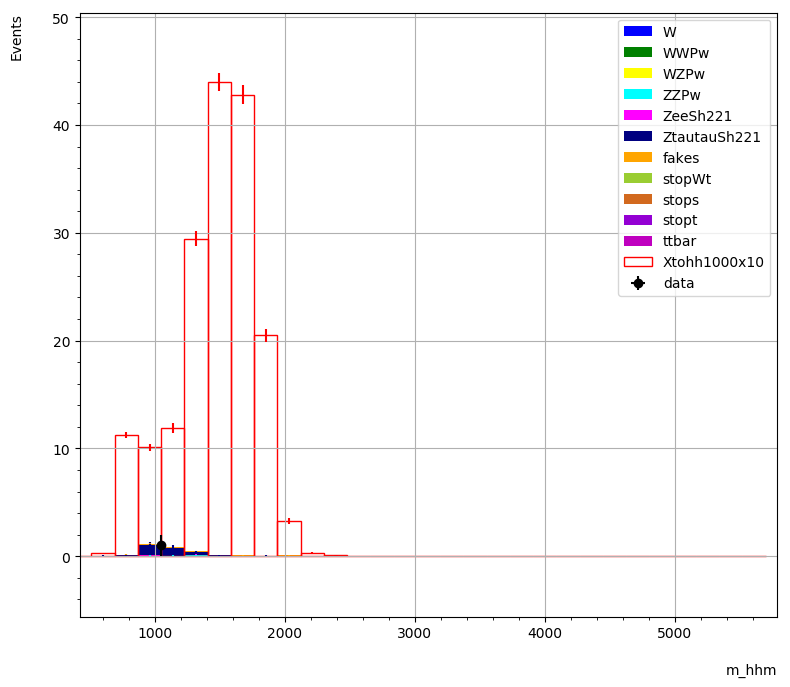

In [83]:
# Base directory
b = "/home/andrea/Escritorio/CERN data/Try3/all.root"
# Background files array
filesB = ['W', 'WWPw', 'WZPw', 'ZZPw', 'ZeeSh221', 'ZtautauSh221', 'fakes', 'stopWt', 'stops', 'stopt', 'ttbar'] 
# Signal files array
filesS = ['Xtohh1000']
# Data files array
filesD = ['data']
# Histogram generation
intB, intS, intD = hist_gen(b, filesD, filesB, filesS, "Nominal", "m_hhm", "SR_2tag", 30)

In [19]:
print("Variable: m_hhm. Region: SR_0tag\n")
print("Background Histogram Integrals:\n")
for i, b in enumerate(filesB):
      print(b+": "+str(intB[i]))
print("\nData Histogram Integrals:\n")
for i, d in enumerate(filesD):
      print(d+": "+str(intD[i]))
print("\nSignal Histogram Integrals:\n")
for i, s in enumerate(filesS):
      print(s+": "+str(intS[i]))


Variable: m_hhm. Region: SR_0tag

Background Histogram Integrals:

W: 20.82041275681695
WWPw: 1.0295338034629822
WZPw: 8.52818301320076
ZZPw: 3.4180157519876957
ZeeSh221: 24.667589388787746
ZtautauSh221: 330.7160491421819
fakes: 69.93252921185984
stopWt: 0.7420827834866941
stops: 0.06830841116607189
stopt: 0.8999953418970108
ttbar: 18.40196979045868

Data Histogram Integrals:

data: 434.0

Signal Histogram Integrals:

Xtohh1000: 4.341462508775294


## TODO:

- Cambiar los colores. https://root.cern.ch/root/html528/TColor.html
- Al generar los histogramas, abajo de este se debe calcular ((Data-bkg_tot)/bkg_tot) y los Residuos (que se verían como puntos de datos). Adjuntar ambos a una sección bajo el histograma, con TRatioPlot.
- Arreglar formato de plot. https://root.cern.ch/doc/master/classTHistPainter.html#HP01
- Calcular integral de los histogramas (chicos) y ponerlos en una tabla como las de https://drive.google.com/drive/folders/1uT9_wIXakyynkumyXaK2slr9T8IR-JIz. 
- https://git.km3net.de/km3py/km3pipe/commit/f8b1d0ad4c14695d9cc0693697742a914e568221
